# Basic clustering

In this notebook we:

* normalize the directions,
* represent them as feature vectors (via TF-IDF),
* visualise the vectors,
* run a simple K-Means clustering algorithm to see where it gets us.

## Before we start: globals and paths

In [1]:
import os

In [2]:
directions_path = ".." + os.sep + "directions"
csv_path = "." + os.sep + "csv"
corpus_path = ".." + os.sep + "RusDraCor"

## Loading data

In [3]:
import pandas as pd
import numpy as np

### Plays

In [4]:
play_df = pd.read_csv(csv_path + os.sep + "joint_data.csv", sep=";", 
                 encoding="utf-8", index_col=0)
play_df.head()

,Amount of acts,Amount of directions,Author,Lemmas,Lemmas per direction,Published,Title,Words,Words per direction,Written,Directions per act,Words per act,Lemmas per act,A,ADV,INTJ,S,V,Words.1
blok-balaganchik.txt,1,38,"Блок, Александр Александрович",910,22.263158,1906,Балаганчик,2240,22.736842,1906,38.000000,2240.000000,910.000000,2.684211,1.210526,0.000000,0,0.342105,10.157895
blok-korol-na-ploschadi.txt,3,133,"Блок, Александр Александрович",1475,14.631579,1907,Король на площади,5535,12.466165,1906,44.333333,1845.000000,491.666667,1.090226,0.977444,0.000000,0,0.218045,5.398496
blok-neznakomka.txt,1,80,"Блок, Александр Александрович",1342,18.025000,1907,Незнакомка,4222,16.462500,1906,80.000000,4222.000000,1342.000000,1.900000,1.050000,0.000000,0,0.350000,7.412500
bulgakov-dni-turbinyh.txt,4,372,"Булгаков, Михаил Афанасьевич",2901,5.634409,1955,Дни Турбиных,16426,3.739247,1926,93.000000,4106.500000,725.250000,0.314516,0.134409,0.005376,0,0.099462,1.295699
bulgakov-ivan-vasilevich.txt,3,319,"Булгаков, Михаил Афанасьевич",2195,6.507837,1965,Иван Васильевич,10303,4.721003,1936,106.333333,3434.333333,731.666667,0.210031,0.163009,0.000000,0,0.100313,1.463950


### Directions

In [5]:
all_directions_path = directions_path + os.sep + "all_directions.txt"
with open(all_directions_path, "r", encoding="utf-8") as alldirs_file:
    alldirs = [line.strip("\n") for line in alldirs_file.readlines() if line.strip("\r\n")]

Let's see how many directions we've got now...

In [6]:
len(alldirs)

17981

...and take a look at an example of direction. For instance, at the last one:

In [7]:
alldirs[-1]

'пролетов, потом слуга'

## Preprocessing

### Text normalization

In order to make clustering easier, I'll normalize all the directions as following:

* the words will be turned into their normal form (i.e. _играл -> играть_, _стулья -> стул_, etc.),
* stop words (such as interjections) will be removed.

The directions are all lowercase already.

In [8]:
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
import string

morph = MorphAnalyzer()
stops = stopwords.words("russian")

In [9]:
def normalize(text):
    text = text.lower()
    
    tokens = wordpunct_tokenize(text)
    
    lemmas_raw = [morph.parse(token)[0].normal_form for token in tokens]
    lemmas = [lemma for lemma in lemmas_raw 
              if lemma not in stops 
             and lemma not in string.punctuation]
    
    return " ".join(lemmas)

In [10]:
alldirs_norm = [normalize(line) for line in alldirs if normalize(line)]

Let's check whether this caused a change in amount of directions:

In [11]:
len(alldirs) != len(alldirs_norm)

True

And also let's take a look at a random direction when it's normalized:

In [12]:
alldirs_norm[-1]

'пролёт слуга'

### Vectorizing

I'm vectorizing the directions because it's the easiest way to get numbers out of texts. The algorithm is **TF-IDF**, which is quite common for the NLP tasks and problems. 

More information:
* [scikit-learn page](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with documentation on functions and parameters,
* _I'll probably add an article on that, but I have to find it first! :)_

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit(alldirs_norm)
X = tfidf.transform(alldirs_norm)

## Plotting the results

Now, let's plot what we have to see whether there are any clusters. Unfortunately, we have our TF-IDF results as a sparse matrix, so we'll run a **LSA (latent semantic analysis)** to reduce the number of dimensions down to 2 in order to be able to plot them.

In [15]:
from sklearn.decomposition import TruncatedSVD

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
svd = TruncatedSVD(n_components=2)
svd.fit(X)
X_2d = svd.transform(X)

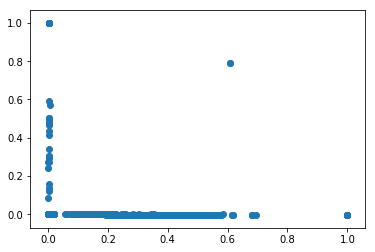

In [18]:
plt.scatter(X_2d[:,0], X_2d[:,1])

## Yay, machine learning!

I'll use **KMeans clustering** algorithm because we have medium amount of directions and 8 clusters (see in [readme](./README.md) — all the classes from TEI classification except for `mixed`). The classes are:

1. setting,
2. entrance,
3. exit,
4. business,
5. novelistic,
6. delivery,
7. modifier,
8. location.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k_means = KMeans(n_clusters=8)
k_means.fit(X)